## SAC
SAC (Soft Actor-Critic) კიდევ ერთი Actor-Critic ალგორითმია, თუმცა ეს იყენებს სამ ნეირონულ ქსელს Actor-ის ქსელი ითვლის ქმედებების გადანაწილებას ანუ მოცემული მდგომარებისთვის საშუალოს და საშუალო კვადრატულ გადახრას
<br>
<br>
თავიდან ჩემი მიზანი იყო Bipedal-Walker-ის ამოცანის ამოხსნა SAC-ით, ამისთვის სხვადასხვა ონლაინ რესურსების გამოყენებით დავწერე ჩემი SAC-ის იმპლემენტაცია, თუმცა, როგორც არ უნდა შემეცვალა მალევე, რაღაც ლოკალურ მინიმუმში იჭედებოდა, Ant-ზეც მსგავსი შედეგი დადო, თუმცა გადარჩენა მაინც ისწავლა. ვცადე ყოველ სტეპზე სწავლის იტერაციის გაშვება და ასევე ყოველი ეპიზოდის ბოლოს, მაგრამ ორივემ მაინც იგივე შედეგი დადო და learning rate-ის ჩაწევამ იმდენად შეანელა სწავლება, რომ მოთმინება არ მეყო.

ჩემი იმპლემენტაცია დავწერე შემდეგი ფსევდო კოდის მიხედვით.(ფსევდო კოდი აღებულია openai-ს საიტიდან https://spinningup.openai.com/en/latest/algorithms/sac.html)

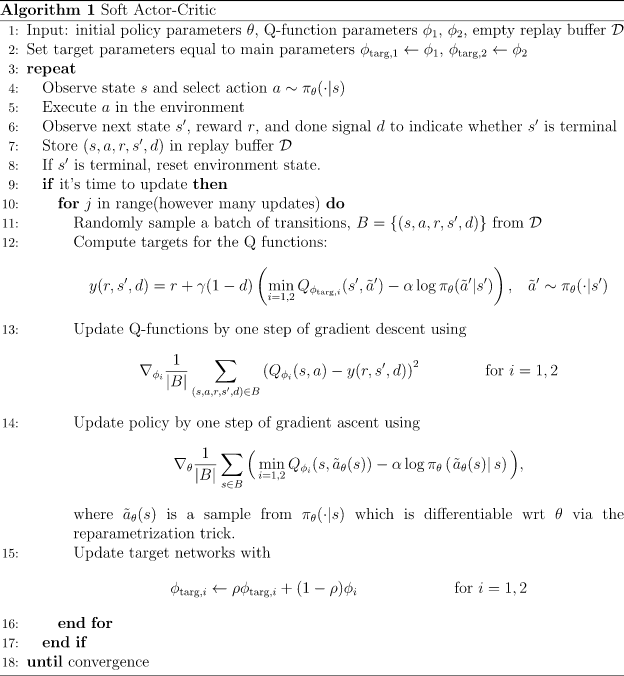

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

from PIL import Image
from IPython.display import Image as ipImage

import os

/home/luka/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-20 17:38:09.373184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 17:38:11.756041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/luka/.mujoco/mujoco210/bin:/lib/:/lib/:/home/luka/miniconda3/envs/tf/lib/:/home/luka/miniconda3/envs/tf/lib/:/home/luka/miniconda3/

ჩემი MemoryBuffer-ის იმპლემენტაცია, რომელშიც შევინახავთ აგენტის მიღებულ გამოცდილებას და შემდეგ ამოვიღებთ რენდომ ბაჩებს და მათ მიხედვით განვაახლებთ ნეირონული ქსელის წონებს. Buffer-ის გამოყენება ზრდის სწავლების ეფექტურობას და რანდომ ბაჩები უმარტივებს აგენტს გამოცდილების განზოგადებას

In [2]:
class MemoryBuffer:
    def __init__(self, max_size, state_shape, action_size):
        self.max_size = max_size
        self.idx = 0

        self.states = np.zeros((self.max_size, *state_shape))
        self.actions = np.zeros((self.max_size, action_size))
        self.next_states = np.zeros((self.max_size, *state_shape))
        self.rewards = np.zeros(self.max_size)
        self.dones = np.zeros(self.max_size)

    def put(self, state, action, next_state, reward, done):
        
        save_idx = self.idx % self.max_size

        self.states[save_idx] = state
        self.actions[save_idx] = action
        self.next_states[save_idx] = next_state
        self.rewards[save_idx] = reward
        self.dones[save_idx] = done

        self.idx += 1

    
    def get_sample(self, sample_size):
        stored_size = min(self.idx, self.max_size)

        sample_idx = np.random.choice(stored_size, sample_size)

        states = self.states[sample_idx]
        actions = self.actions[sample_idx]
        next_states = self.next_states[sample_idx]
        rewards = self.rewards[sample_idx]
        dones = self.dones[sample_idx]

        return states, actions, next_states, rewards, dones

SAC-ის უფრო ძველ ვარიანტებში 3 განსხვავებული ნეირონული ქსელია გამოყენებული, თუმცა მე ვარჩიე უფრო ახალი ვერსია იმპლემენტაციის გამარტივებისთვის.

In [3]:
class CriticNetwork(tf.keras.Model):

    def __init__(self, model_name, checkpoint_dir="sac_checkpoints/"):
        super(CriticNetwork, self).__init__()

        self.model_name = model_name
        self.save_dir = checkpoint_dir
        self.save_file = os.path.join(checkpoint_dir, "sac_" + self.model_name)

        self.d1 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform())
        self.d2 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform())
        self.out = Dense(1, kernel_initializer=tf.keras.initializers.RandomUniform())

    def call(self, state, action):
        res = self.d1(tf.concat([state, action], axis=1))
        res = self.d2(res)
        res = self.out(res)

        return res
    
class ActorNetwork(tf.keras.Model):

    def __init__(self, model_name, action_size, max_action=3, noise=1e-6, checkpoint_dir="sac_checkpoints/"):
        super(ActorNetwork, self).__init__()

        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        self.save_file = os.path.join(checkpoint_dir, "sac_" + self.model_name)
        self.action_size = action_size
        self.max_action = max_action
        self.noise = noise

        self.d1 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform())
        self.d2 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform())

        self.miu = Dense(self.action_size, activation='linear', kernel_initializer=tf.keras.initializers.RandomUniform())
        self.sigma = Dense(self.action_size, activation='linear', kernel_initializer=tf.keras.initializers.RandomUniform())

    def call(self, state):
        res = self.d1(state)
        res = self.d2(res)

        miu = self.miu(res)

        sigma = self.sigma(res)

        sigma = tf.clip_by_value(sigma, self.noise, 1) # 0 რომ არ იყოს

        return miu, sigma
    
    def sample(self, state):
        miu, sigma = self.call(state)
        pdf = tfp.distributions.Normal(miu, sigma)

        actions = pdf.sample()

        action = tf.math.tanh(actions) * self.max_action

        log_probs = pdf.log_prob(actions)
        log_probs -= tf.reduce_sum(tf.math.log(1 - tf.math.square(action) + self.noise), axis=1, keepdims=True)

        return action, log_probs

სწავლების გასტაბილურებისთვის SAC იყენებს დამატებით ნეირონულ ქსელებს, რომლის წონებიც უფრო ნელა განახლდება. ამის არსი იმაში მდგომარეობს, რომ ასე სწავლება, როდესაც ახალ გზას დაადგება ძველ ინფორმაციას ნაკლებად დაივიწყებს

In [11]:
class SAC_Agent:

    def __init__(self, action_space, observation_space, actor_lr, critic_lr, alpha, gamma, tau, buffer_size, batch_size, reward_scale) -> None:

        self.action_space = action_space
        self.observation_space = observation_space

        self.buffer = MemoryBuffer(buffer_size, observation_space.shape, action_space.shape[0])
        self.batch_size = batch_size

        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau

        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        self.actor = ActorNetwork(model_name="actor", action_size=action_space.shape[0], max_action=action_space.high[0], checkpoint_dir="sac_checkpoints")
        
        self.critic1 = CriticNetwork("critic_1")
        self.critic2 = CriticNetwork("critic_2")

        self.critic1_target = CriticNetwork("critic_1_target")
        self.critic2_target = CriticNetwork("critic_2_target")

        self.actor.compile(optimizer=Adam(learning_rate=actor_lr))
        self.critic1.compile(optimizer=Adam(learning_rate=critic_lr))
        self.critic2.compile(optimizer=Adam(learning_rate=critic_lr))

        
        self.critic1_target.compile(optimizer=Adam(learning_rate=critic_lr))
        self.critic2_target.compile(optimizer=Adam(learning_rate=critic_lr))


        self.scale = reward_scale

        self.update_target_weights(tau=1)

    def policy(self, state):
        state = tf.convert_to_tensor([state])
        actions, _ = self.actor.sample(state)

        return actions[0]
    
    def save_observation(self, state, action, next_state, reward, done):
        self.buffer.put(state, action, next_state, reward, done)

    def calc_actor_loss(self, states):
        policy_actions, log_probs = self.actor.sample(states)
        q1 = self.critic1(states, policy_actions)
        q2 = self.critic2(states, policy_actions)

        min_q = tf.minimum(q1, q2)

        soft_q = min_q - self.alpha * log_probs

        return tf.math.reduce_mean(soft_q)
    
    def calc_critic_losses(self, states, actions, next_states):
        q1 = self.critic1(states, actions)
        q2 = self.critic2(states, actions)

        action, log_prob = self.actor.sample(states)

        q1_target = self.critic1_target(next_states, action)
        q2_target = self.critic2_target(next_states, action)

        min_q = tf.minimum(q1_target, q2_target)

        soft_q = min_q - self.alpha * log_prob

        critic1_loss = tf.keras.losses.MSE(q1, soft_q)
        critic2_loss = tf.keras.losses.MSE(q2, soft_q)

        return critic1_loss, critic2_loss
    
    def apply_gradients(self):
        states, actions, next_states, rewards, dones = self.buffer.get_sample(self.batch_size)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)


        with tf.GradientTape(persistent=True) as tape:
            critic1_loss, critic2_loss = self.calc_critic_losses(states, actions, next_states)

        critic1_grad = tape.gradient(critic1_loss, self.critic1.trainable_variables)
        critic2_grad = tape.gradient(critic2_loss, self.critic2.trainable_variables)
        self.critic1.optimizer.apply_gradients(zip(tf.multiply(self.critic_lr, critic1_grad), self.critic1.trainable_variables))
        self.critic2.optimizer.apply_gradients(zip(tf.multiply(self.critic_lr, critic2_grad), self.critic2.trainable_variables))

        with tf.GradientTape() as tape:
            actor_loss = self.calc_actor_loss(states)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(tf.multiply(self.actor_lr, actor_grad), self.actor.trainable_variables))
    
    def learn(self):
        self.apply_gradients()
        self.update_target_weights(tau=self.tau)
        

    def update_target_weights(self, tau):
        self.update_model_weights(self.critic1_target, self.critic1, tau)
        self.update_model_weights(self.critic2_target, self.critic2, tau)
    
    def update_model_weights(self, model_to_update, model_to_update_from, tau):

        mtu_weights = model_to_update.weights
        
        new_weights = []
        for i, weight in enumerate(model_to_update_from.weights):
            new_weights.append(tau * weight + (1 - tau) * mtu_weights[i])
        
        model_to_update.set_weights(new_weights)

    def save_model(self):
        self.actor.save_weights(self.actor.save_file)
        self.critic1.save_weights(self.critic1.save_file)
        self.critic2.save_weights(self.critic2.save_file)
        self.critic1_target.save_weights(self.critic1_target.save_file)
        self.critic2_target.save_weights(self.critic2_target.save_file)
    
    def load_model(self):
        self.actor.load_weights(self.actor.save_file)
        self.critic1.load_weights(self.critic1.save_file)
        self.critic2.load_weights(self.critic2.save_file)
        self.critic1_target.load_weights(self.critic1_target.save_file)
        self.critic2_target.load_weights(self.critic2_target.save_file)

საკმაოდ მარტივი სწავლების ციკლი, სწავლების დასაწყისში ვირჩევთ რენდომ ქმედებებს, რათა აგენტის გამოცდილება უფრო მრავალფეროვანი გავხადოთ. SAC-ი რადგანაც, რეალურად, ალბათურ განაწილებას ითვლის, უკვე რაღაც ალბათობით უსწავლელ ნაბიჯს გადაგავს, თუმცა start_steps მაინც დაგვიცავს იმისგან, რომ საწყისი წონები ეგრევე ლოკალურ მინიმუმში გაჭედავს აგენტს.

In [12]:
def run_sac_training(agent: SAC_Agent, time_steps, env, start_steps=5000, render=False):

    episodic_rewards = []
    avg_episodic_rewards = []

    best_result = -10000

    best_result_history = []

    steps_count = 0
    episode_num = 0
    while True:
        
        episode_num += 1

        episode_reward = 0

        state, _ = env.reset()

        while True:

            if render:
                env.render()

            if steps_count >= start_steps:
                action = agent.policy(state)
            else:
                action = env.action_space.sample()
            
            next_state, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated

            agent.save_observation(state, action, next_state, reward, done)

            episode_reward += reward
            
            steps_count += 1

            if done:
                break
        
        episodic_rewards.append(episode_reward)
        avg_reward = np.mean(episodic_rewards[-64:])
        avg_episodic_rewards.append(avg_reward)
        print(f"Episode #{episode_num}: TimeStep: {steps_count} Reward: {episode_reward}, Mean: {avg_reward}")

        if avg_reward > best_result:
            print("New best avg achieved!!!")
            best_result = avg_reward
            best_result_history.append(best_result)
            agent.save_model()
        
        if time_steps < steps_count:
            break
        
        agent.learn()
    
    return episodic_rewards, avg_episodic_rewards, best_result_history

In [13]:
env = gym.make("Ant-v4")

### ჰიპერპარამეტრები
ჰიპერპარამეტრები ავირჩიე საკმაოდ სტანდარტული და მათი ცვლილებით შედეგიც დიდად არ იცვლება, სავარაუდოდ tensorflow-ს ბიბლიოთეკაში რაღაც ფუნქციას არასწორედ ვიყენებ, თუმცა სხვების იმპლემენტაციისგან ძალიან განსხვავებული არ ვიყავი.

In [14]:
agent = SAC_Agent(
        action_space=env.action_space,
        observation_space=env.observation_space,
        actor_lr=3e-4,
        critic_lr=3e-4,
        alpha=0.2,
        gamma=0.99,
        tau=0.005,
        buffer_size=100_000,
        batch_size=64,
        reward_scale=2,
    )

In [ ]:
episodic_rewards, avg_episodic_rewards, best_result_history = run_sac_training(agent, 100_000, env)

In [24]:
agent.save_model()

In [19]:
agent.load_model()

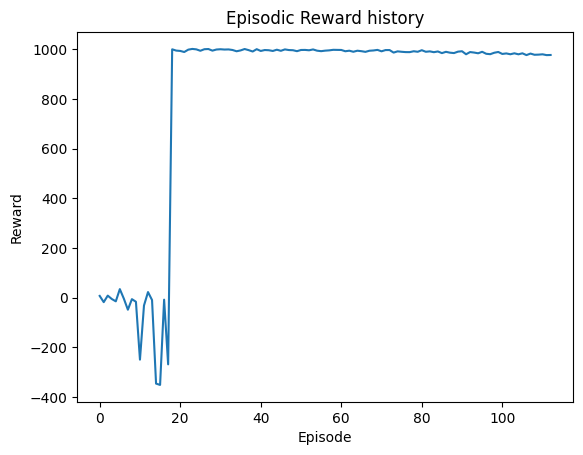

In [25]:
plt.plot(episodic_rewards)

plt.title('Episodic Reward history')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.savefig('Episodic_Reward_History.png')

Text(0, 0.5, 'Avg. Reward')

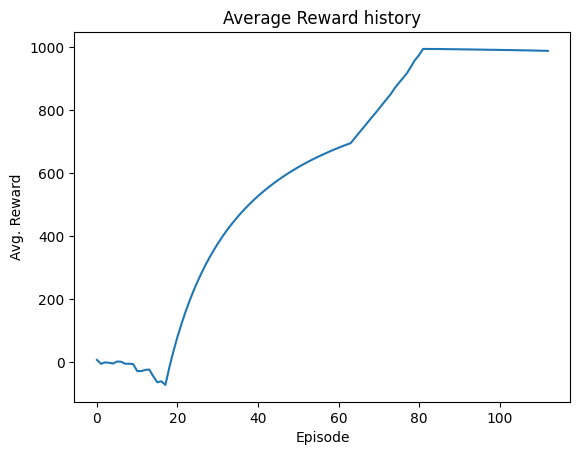

In [26]:
plt.clf()
plt.plot(avg_episodic_rewards)
plt.title('Average Reward history')
plt.xlabel('Episode')
plt.ylabel('Avg. Reward')

In [28]:
print(best_result_history)

[7.129351594142387, 34.53389157956086, 80.20021546701422, 121.519701975417, 159.6575756562843, 194.73960857193526, 226.94440022135103, 256.4540338927854, 284.0077724996968, 309.62084401608007, 333.2451607547913, 355.44498724880265, 376.24683976880686, 395.71184385451363, 414.01215529279614, 431.1671380451605, 447.1961797396494, 462.43027856651366, 476.992100777035, 490.66955750349973, 503.5043170134942, 515.9310171187732, 527.577895513295, 538.7578054998082, 549.3992315691656, 559.4905599180362, 569.2452349925343, 578.4796634540453, 587.4409832352779, 595.9745505325459, 604.1470581134491, 611.9148815538684, 619.4724095820714, 626.7444153997118, 633.7144103624413, 640.4884868366967, 646.9256404040256, 653.0987611204162, 659.0912344471402, 664.8967721870918, 670.5428317145487, 675.9953625942472, 681.2651807592895, 686.2811151757962, 691.1723763755407, 695.8444547746358, 711.2703694507258, 727.0593582283362, 742.3953459988229, 758.0138175499294, 773.7976385987093, 788.8475130608724, 804.4

ამის მიუხედავად შედეგი არაა ძალიან ცუდი ჭიანჭველამ გადარჩენა ისწავლა, თუმცა მოძრაობა ვერა, დგომა ისწავლა ;)

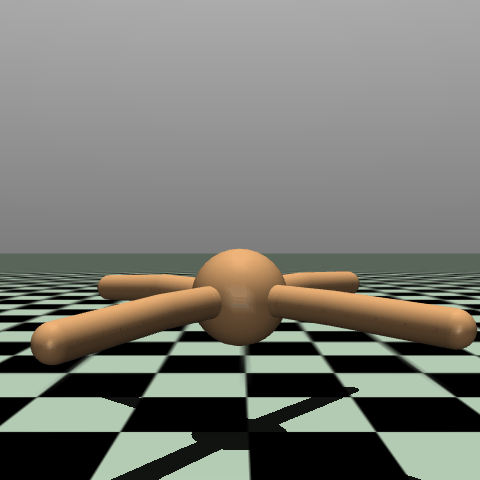

In [23]:
env = gym.make('Ant-v4', render_mode='rgb_array')
obs, _ = env.reset()

img_list = []

for t in range(1000):
    img = env.render()
    img_list.append(Image.fromarray(img))
    
    action = agent.policy(obs)
    
    obs, reward, terminated, truncated, _ = env.step(action)
    
    if terminated or truncated:
        obs = env.reset()

img_list[0].save('gifs/sac.gif', save_all=True, append_images=img_list[1:], optimize=False, duration=50, loop=0)
ipImage(filename="gifs/sac.gif")
env.close()
